# 1. Import Required Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 2.  Load & Clean Data 

In [6]:
df = pd.read_csv("21.5.2025.csv")  
df = df[['timestamp', 'x_snap', 'y_snap']].dropna()
df = df.sort_values(by='timestamp').reset_index(drop=True)

In [7]:
df

,timestamp,x_snap,y_snap
0,1747814734396,44.1433,21.9221
1,1747814739621,39.7879,25.2254
2,1747814745137,32.0325,25.7593
3,1747814751243,24.0550,25.2953
4,1747814759377,18.3781,23.9325
...,...,...,...
184,1747816010912,14.7280,32.0287
185,1747816016000,14.7193,32.0223
186,1747816021068,14.7243,32.0293
187,1747816032825,13.5602,31.3723


# 3. IQR Outlier Removal + Kalman Filter

In [8]:
import numpy as np
import pandas as pd

def kalman_filter_2d(x_data, y_data, process_var=1e-4, meas_var=1e-2):
    n = len(x_data)

    # State estimate: position only (x, y)
    xhat = np.zeros((n, 2))  # filtered values
    P = np.ones((n, 2))      # uncertainties per dimension

    # Initialize with first values
    xhat[0, 0] = x_data[0]
    xhat[0, 1] = y_data[0]
    P[0, :] = 1.0

    for k in range(1, n):
        # Prediction step
        xhat[k] = xhat[k-1]
        P[k] = P[k-1] + process_var

        # Update step for both x and y
        K = P[k] / (P[k] + meas_var)
        xhat[k, 0] += K[0] * (x_data[k] - xhat[k, 0])
        xhat[k, 1] += K[1] * (y_data[k] - xhat[k, 1])
        P[k] = (1 - K) * P[k]

    return xhat[:, 0], xhat[:, 1]

# Apply on your DataFrame
x_kf, y_kf = kalman_filter_2d(df['x_snap'].values, df['y_snap'].values)
df['x_kalman'] = x_kf
df['y_kalman'] = y_kf

In [9]:
df

,timestamp,x_snap,y_snap,x_kalman,y_kalman
0,1747814734396,44.1433,21.9221,44.143300,21.922100
1,1747814739621,39.7879,25.2254,39.831019,25.192697
2,1747814745137,32.0325,25.7593,35.931564,25.476013
3,1747814751243,24.0550,25.2953,31.920144,25.414975
4,1747814759377,18.3781,23.9325,28.425921,25.032456
...,...,...,...,...,...
184,1747816010912,14.7280,32.0287,17.189529,28.273332
185,1747816016000,14.7193,32.0223,16.954549,28.629952
186,1747816021068,14.7243,32.0293,16.742397,28.953315
187,1747816032825,13.5602,31.3723,16.439690,29.183421


# 4. Create Sliding Window Dataset

In [10]:
# === Create sliding window input features ===
window_size = 10

X, y = [], []
for i in range(window_size, len(df) - 1):
    window = df[['x_kalman', 'y_kalman']].iloc[i-window_size:i].values.flatten()
    next_pos = df[['x_kalman', 'y_kalman']].iloc[i + 1].values
    X.append(window)
    y.append(next_pos)

X = np.array(X)
y = np.array(y)


In [11]:
X.shape, y.shape

((178, 20), (178, 2))

# 5. Train/ Val/ Test/ GT Split

In [12]:
X_trainval, X_test_gt, y_trainval, y_test_gt = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)
X_test, X_gt, y_test, y_gt = train_test_split(X_test_gt, y_test_gt, test_size=0.5, random_state=42)

# 6. Train Random Forest

In [30]:
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    )

# Fit Model 
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 0.6018
Validation RMSE: 1.6434
Test RMSE: 1.3915


# 7. Recursive 10-Step Prediction 

In [31]:
def predict_recursive(model, start_window, n_steps=20):
    preds = []
    window = start_window.copy()
    for _ in range(n_steps):
        pred = model.predict(window.reshape(1, -1))[0]
        preds.append(pred)
        window = np.roll(window, -2)
        window[-2:] = pred
    return np.array(preds)

start_window = X_gt[0]
n_steps=10
pred_path = predict_recursive(model, start_window, n_steps=n_steps)

# 8. Extract True Ground Truth Path

In [32]:
# Locate index in DataFrame
start_x, start_y = start_window[-2], start_window[-1]
dists = np.sqrt((df['x_kalman'] - start_x)**2 + (df['y_kalman'] - start_y)**2)
start_idx = dists.idxmin()

true_gt_path = df[['x_kalman', 'y_kalman']].iloc[start_idx + 1: start_idx + 1 + n_steps].values

# 9. Plot Reference, Trajectories & Save

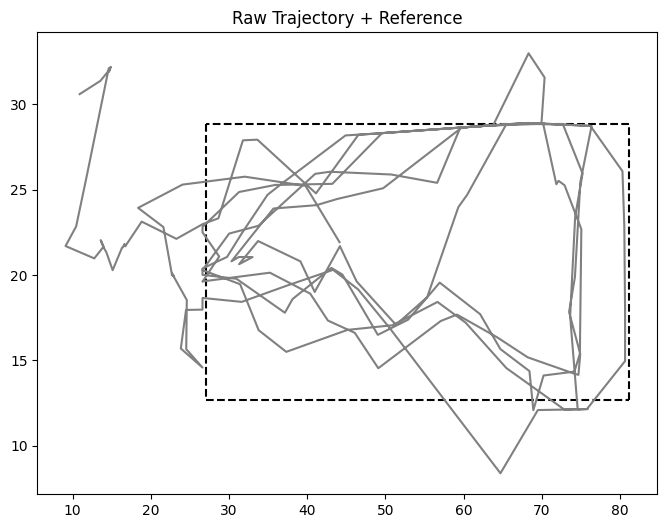

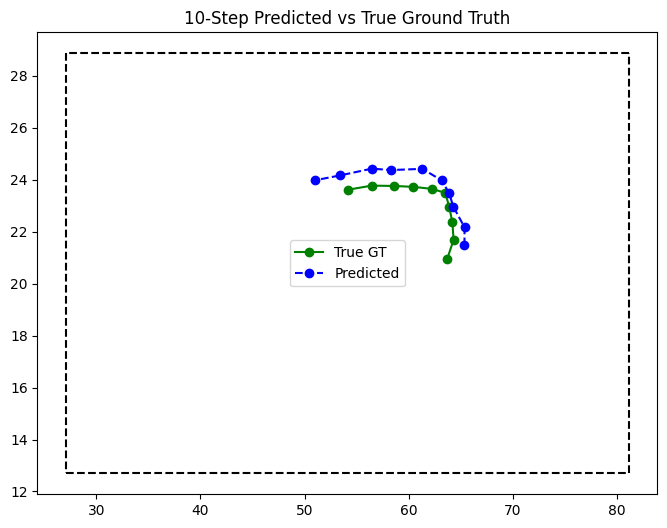

In [33]:
os.makedirs("rf_output", exist_ok=True)

polygon_json = "{\"l1\":[[27.05,12.7,0],[81.19,12.7,0]],\"l2\":[[81.19,12.7,0],[81.19,28.87,0]],\"l3\":[[81.19,28.87,0],[27.05,28.87,0]],\"l4\":[[27.05,28.87,0],[27.05,12.7,0]]}"
polygon = json.loads(polygon_json)

def draw_ref_lines():
    for line in polygon.values():
        x = [p[0] for p in line]
        y = [p[1] for p in line]
        plt.plot(x, y, 'k--')

# Raw + ref
plt.figure(figsize=(8, 6))
draw_ref_lines()
plt.plot(df['x_snap'], df['y_snap'], color='gray', label='Raw')
plt.title("Raw Trajectory + Reference")
plt.savefig("rf_output/raw_reference.png")

# True vs Pred
plt.figure(figsize=(8, 6))
draw_ref_lines()
plt.plot(true_gt_path[:, 0], true_gt_path[:, 1], 'g-o', label='True GT')
plt.plot(pred_path[:, 0], pred_path[:, 1], 'b--o', label='Predicted')
plt.title("10-Step Predicted vs True Ground Truth")
plt.legend()
plt.savefig("rf_output/true_gt_vs_predicted.png")

# 10. Plot Losses as Line Chart

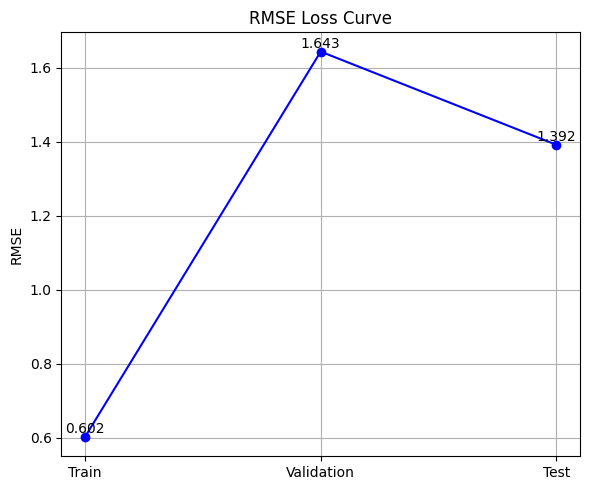

In [34]:
plt.figure(figsize=(6, 5))
loss_labels = ['Train', 'Validation', 'Test']
loss_values = [train_rmse, val_rmse, test_rmse]

plt.plot(loss_labels, loss_values, marker='o', linestyle='-', color='blue')
for i, val in enumerate(loss_values):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center')
plt.title("RMSE Loss Curve")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_output/loss_line_plot.png")
plt.show()

# 11. Step-Wise Euclidean Distance + Plot + CSV file

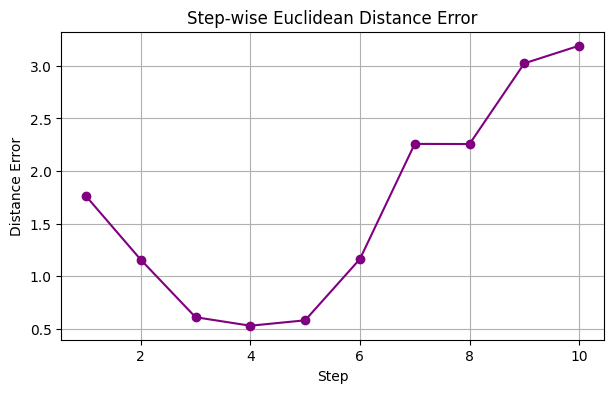

✅ Exported: stepwise_prediction_vs_gt.csv


In [35]:
def euclidean(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

step_errors = [euclidean(p, g) for p, g in zip(pred_path, true_gt_path)]

# Plot
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(step_errors)+1), step_errors, marker='o', color='purple')
plt.title("Step-wise Euclidean Distance Error")
plt.xlabel("Step")
plt.ylabel("Distance Error")
plt.grid(True)
plt.savefig("rf_output/stepwise_error_plot.png")
plt.show()

# CSV
rows = [{
    'step': i+1,
    'gt_x': gt[0],
    'gt_y': gt[1],
    'pred_x': pr[0],
    'pred_y': pr[1],
    'euclidean_distance': dist
} for i, (gt, pr, dist) in enumerate(zip(true_gt_path, pred_path, step_errors))]

df_error = pd.DataFrame(rows)
df_error.to_csv("rf_output/stepwise_prediction_vs_gt.csv", index=False)
print("✅ Exported: stepwise_prediction_vs_gt.csv")

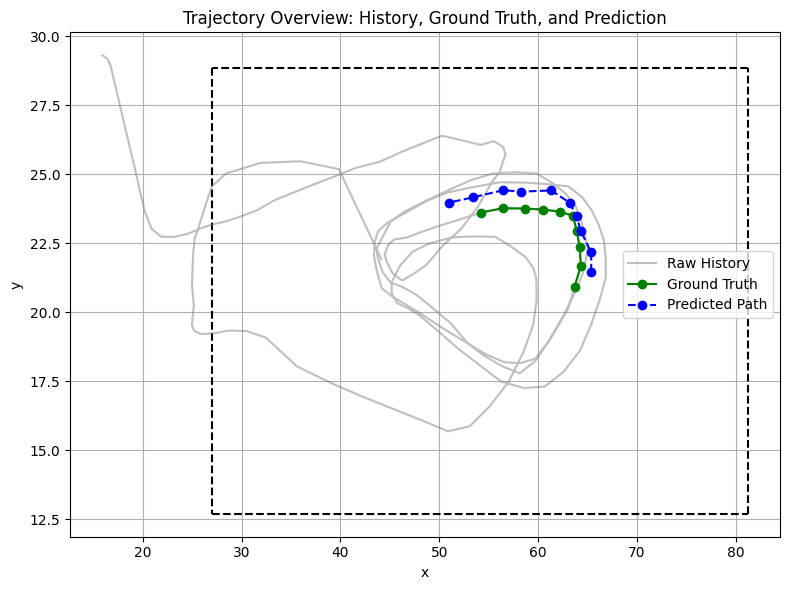

In [36]:
# === Full Combined Plot: History, Predicted Path, Ground Truth ===
plt.figure(figsize=(8, 6))

# Reference polygon
draw_ref_lines()

# Raw history (all past data)
plt.plot(df['x_kalman'], df['y_kalman'], 'gray', alpha=0.5, label='Raw History')

# Ground Truth path (green)
plt.plot(true_gt_path[:, 0], true_gt_path[:, 1], 'g-o', label='Ground Truth')

# Predicted path (blue dashed)
plt.plot(pred_path[:, 0], pred_path[:, 1], 'b--o', label='Predicted Path')

plt.title("Trajectory Overview: History, Ground Truth, and Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_output/full_trajectory_overview.png")
plt.show()

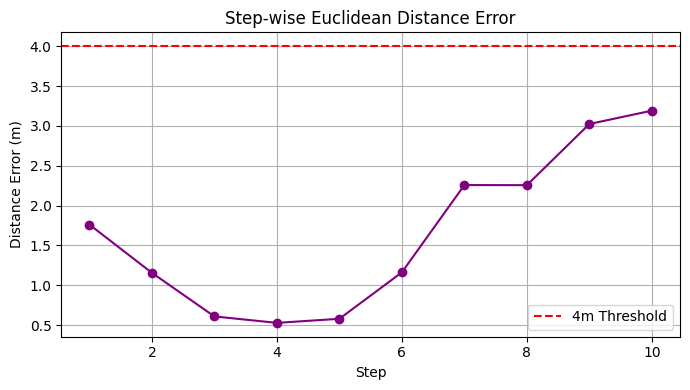

In [37]:
# --- Stepwise Error Plot ---
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(step_errors)+1), step_errors, marker='o', color='purple')
plt.axhline(4.0, linestyle='--', color='red', label="4m Threshold")
plt.title("Step-wise Euclidean Distance Error")
plt.xlabel("Step")
plt.ylabel("Distance Error (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()